In [8]:
# My custom library of photoelastic tools
import sys
#sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')
sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import circularMask
from pepe.simulate import genSyntheticResponse
from pepe.analysis import forceOptimize

import numpy as np
import pickle

#from scipy.optimize import minimize, leastsq
from lmfit import minimize, Parameters, fit_report

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

from IPython.display import clear_output

from PIL import Image, ImageDraw, ImageFont # For creating our text

# For timing
import time

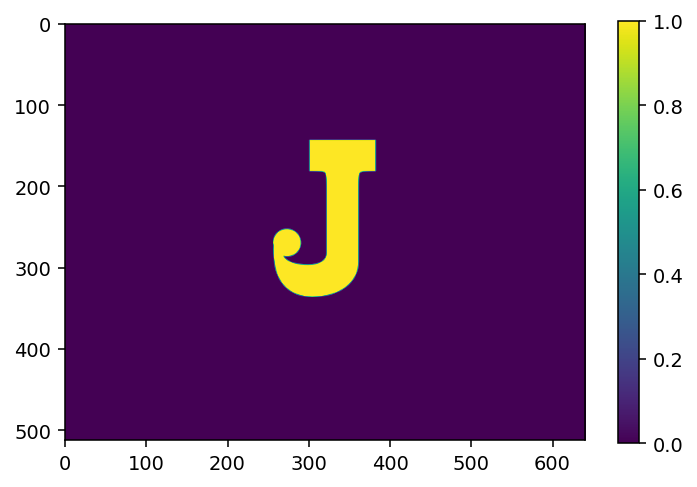

In [21]:
imageShape = (513, 641)
center = np.array([imageShape[0]/2, imageShape[1]/2], dtype=np.int64)
radius = 201

# Generate a fake particle image with text inside of it
text = "J"

font = ImageFont.truetype("RabentoBlack.otf",200)

# Create a blank image any draw our text on it
image = Image.new("RGB", imageShape[::-1])
draw = ImageDraw.Draw(image)

textWidth, textHeight = draw.textsize(text, font)

draw.text((imageShape[1]/2 - textWidth/2, imageShape[0]/2 - textHeight/2-20), text, font=font)

imageArr = np.array(image)[:,:,0] / 255

imageArr = imageArr * circularMask(imageShape, center, radius)[:,:,0]

plt.imshow(imageArr)
plt.colorbar()
plt.show()

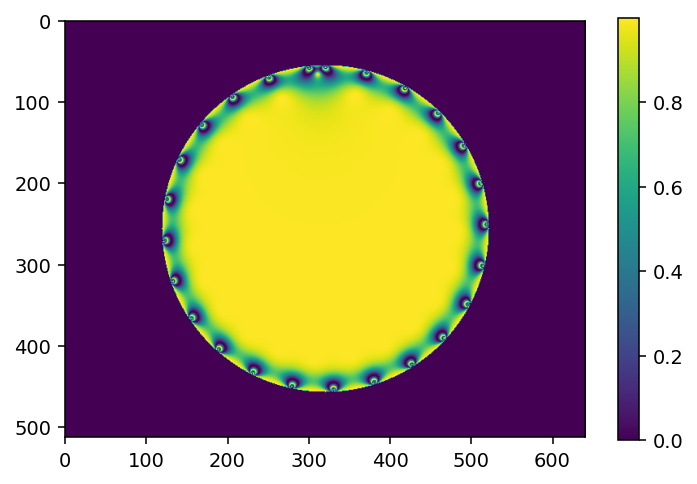

In [22]:
numForces = 25
fSigma = 100.
pxPerMeter = 10000.
brightfield = True

forceGuessArr = np.zeros(numForces) + .1
alphaGuessArr = np.zeros(numForces)
betaGuessArr = np.linspace(np.pi, -np.pi+.1, numForces)

synImage = genSyntheticResponse(forceGuessArr, alphaGuessArr, betaGuessArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

plt.imshow(synImage)
plt.colorbar()
plt.show()

In [23]:
optForceArr = forceGuessArr.copy()
optBetaArr = betaGuessArr.copy()
optAlphaArr = alphaGuessArr.copy()

resArr = []
saveInterval = 10
iterations = 0

In [ ]:
with open('force_alpha_beta.pickle', 'rb') as f:
    arr = pickle.load(f)

optForceArr = arr[0]
optAlphaArr = arr[1]
optBetaArr = arr[2]

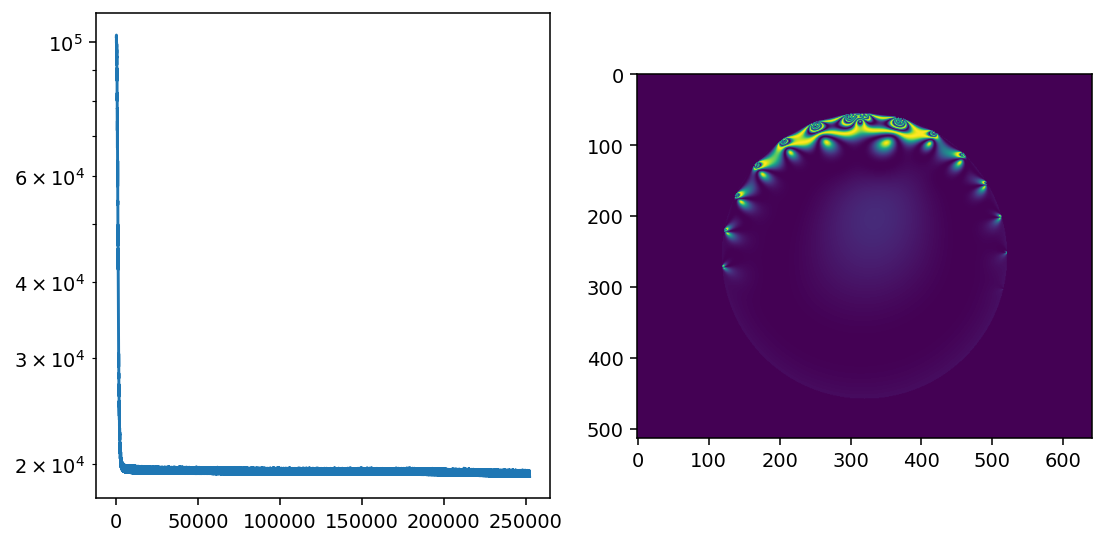

In [ ]:
while True:
    # Now, try and optimize
    optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(optForceArr, optBetaArr, optAlphaArr, radius, center, imageArr,
                                                              fSigma, pxPerMeter, brightfield, maxEvals=200, method='nelder',
                                                              parametersToFit=['f', 'a'], forceTolerance=5., alphaTolerance=1.,
                                                              allowRemoveForces=False, allowAddForces=False)

    resArr = resArr + res
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    
    optImage = genSyntheticResponse(optForceArr, optAlphaArr, optBetaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

    ax[0].plot(resArr)
    ax[0].set_yscale('log')
    ax[1].imshow(optImage)
    
    fig.tight_layout()
    plt.show()
    
    if iterations % saveInterval == 0:
        with open('force_alpha_beta.pickle', 'wb') as f:
            pickle.dump([optForceArr, optAlphaArr, optBetaArr], f)
    
    iterations += 1

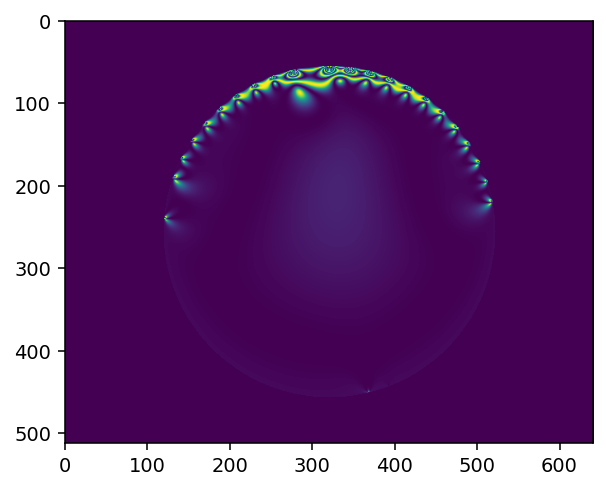

In [20]:
optImage = genSyntheticResponse(optForceArr, optAlphaArr, optBetaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

plt.imshow(optImage)
plt.show()